In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json 
import math 
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer   
import textwrap
import seaborn as sns
import torch
import os

In [4]:
model_name = "google/embeddinggemma-300m"
outdated_models = ["jinaai/jina-embeddings-v3",
          "jinaai/jina-embeddings-v4",
           "Snowflake/snowflake-arctic-embed-l-v2.0", "BAAI/bge-m3", 
           'sentence-transformers/all-MiniLM-L6-v2', 
           'Qwen/Qwen3-Embedding-0.6B']

In [5]:
df = pd.read_parquet('data/speech_embeddings.parquet')

In [6]:
# delete all columns of outdated models
for outdated_model in outdated_models:
    if outdated_model in df.columns:
        del df[outdated_model]

In [7]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu" 
model = SentenceTransformer(model_name, trust_remote_code=True).to(device)

In [29]:
queries = [
    "Immigration is bad",
    "Immigrants’ identity and/or culture is problematic",
    "Immigration is a threat to the European way of life / identity",
    "Arabs and/or Muslims are a cultural/social threat",
    "Certain immigrants are unwilling/incapable to integrate",
    "Immigration is a threat to individual safety",
    "Immigration is a threat to national security",
    "Immigrants are prone to committing crimes (violent, non-violent, organised, sexual)",
    "Many immigrants are terrorists",
    "Immigrants spread diseases",
    "There are too many immigrants coming",
    "Our borders are strained and/or insufficiently controlled",
    "Immigrants do not contribute to the economy",
    "Immigrants take our jobs",
    "Many asylum seekers are actually economic migrants",
    "Immigrants abuse the welfare system",
    "Immigrants are a strain on our health-care system",
    "Immigrants are a strain on the housing market",
    "Immigration reduces the attractiveness of location and lowers overall life quality",
    "Immigrants are victims of human traffickers",
    "Certain immigrants /asylum seekers are discriminated against",
    "EU is in breach of international law",
    "Immigration is abused as a political tool",
    "EU is harmful for our nation",
    "Let’s overthrow the establishment",
    "Political rivals act against the interests of the people",
    "We are being silenced",
    "Mainstream media are biased",
    "Immigrants suffer from labour exploitation"
]

In [30]:
query_dictionary = {
    "anti_immigration" :     ["Immigration is bad",
    "Immigrants’ identity and/or culture is problematic",
    "Immigration is a threat to the European way of life / identity",
    "Arabs and/or Muslims are a cultural/social threat",
    "Certain immigrants are unwilling/incapable to integrate",
    "Immigration is a threat to individual safety",
    "Immigration is a threat to national security",
    "Immigrants are prone to committing crimes (violent, non-violent, organised, sexual)",
    "Many immigrants are terrorists",
    "Immigrants spread diseases",
    "There are too many immigrants coming",
    # "Our borders are strained and/or insufficiently controlled",
    "Immigrants do not contribute to the economy",
    "Immigrants take our jobs",
    "Many asylum seekers are actually economic migrants",
    "Immigrants abuse the welfare system",
    "Immigrants are a strain on our health-care system",
    "Immigrants are a strain on the housing market",
    "Immigration reduces the attractiveness of location and lowers overall life quality"],
    "immigrants_as_victims": ["Immigrants are victims of human traffickers",
    "Certain immigrants /asylum seekers are discriminated against",
    "EU is in breach of international law",
    "Immigrants suffer from labour exploitation"],
    "populist/anti-elitist": ["EU is harmful for our nation",
    "Let’s overthrow the establishment",
    "Political rivals act against the interests of the people",
    "We are being silenced",
    "Mainstream media are biased"]
}

In [31]:
# embed queries
query_embeddings = model.encode_query(queries, batch_size=32)

In [32]:
# compute cosine similarity between query embeddings and speech embeddings
for i, query_embedding in enumerate(query_embeddings):
    column_name = queries[i]
    df[column_name] = df[model_name].apply(lambda x: cosine_similarity([query_embedding], [x])[0][0])

In [33]:
def top_speeches(df, query, n=5):
    top = df.nlargest(n, query)
    print(f"Top {n} speeches for query: '{query}'")
    for _, row in top.iterrows():
        print(f"{row['speaker']}  (sim={row[query]:.4f})")
        print(textwrap.fill(row['translatedText'], width=90))
        print()
    print("--------------------------------------------------\n")

In [34]:
for query in queries:
    top_speeches(df, query, n=5)

Top 5 speeches for query: 'Immigration is bad'
Catherine Stihler  (sim=0.5220)
I voted against this report. The language used in the paragraph regarding the
‘uncontrolled influx of immigrants’ is unhelpful in the context of this report and the
wider refugee crisis debate.

Nadine Morano  (sim=0.4929)
I abstained on this report, certain provisions of which clearly constituted a call for
illegal immigration. Indeed, by asking to integrate migrants, who have not even obtained
refugee status and are therefore illegal immigrants, into the various education and
training programs, this text suggests that we can with dignity welcome migrants in Europe,
when in reality we are not able to provide them with housing, employment or the means to
assimilate properly.

Gilles Lebreton  (sim=0.4887)
I voted against this report because it will facilitate immigration, whereas we should
rather dissuade migrants from coming to Europe.

Auke Zijlstra  (sim=0.4852)
There are few good developments in immigrat

In [35]:
# aggregate over parties and years: compute mean similarity per query and number of speeches
agg = (
    df
    .groupby(["block", "year"])
    .agg({q: "mean" for q in queries})
    .reset_index()
)

# add number of speeches per group
counts = df.groupby(["block", "year"]).size().reset_index(name="n_speeches")
agg = agg.merge(counts, on=["block", "year"])

## Plot cosine similarities for every party over time

In [36]:
with open('plotting_parameters/color_maps/color_map_block.json') as f:
    color_map = json.load(f)

In [37]:
def mean_similarity_plots(ax, df, query):
    sns.lineplot(data=df, x='year', y=query, hue='block', marker='o', palette=color_map, ax=ax, errorbar='se')
    ax.set_title(query[:60] + ("..." if len(query) > 60 else ""))
    ax.set_ylabel("Mean Cosine Similarity")
    ax.set_xlabel("Year")
    # ax.legend(title='Party Block')
    ax.grid(True)

In [38]:
queries = [    "Immigrants are victims of human traffickers",
    "Certain immigrants /asylum seekers are discriminated against",
    "EU is in breach of international law",
    "Immigrants suffer from labour exploitation"
]

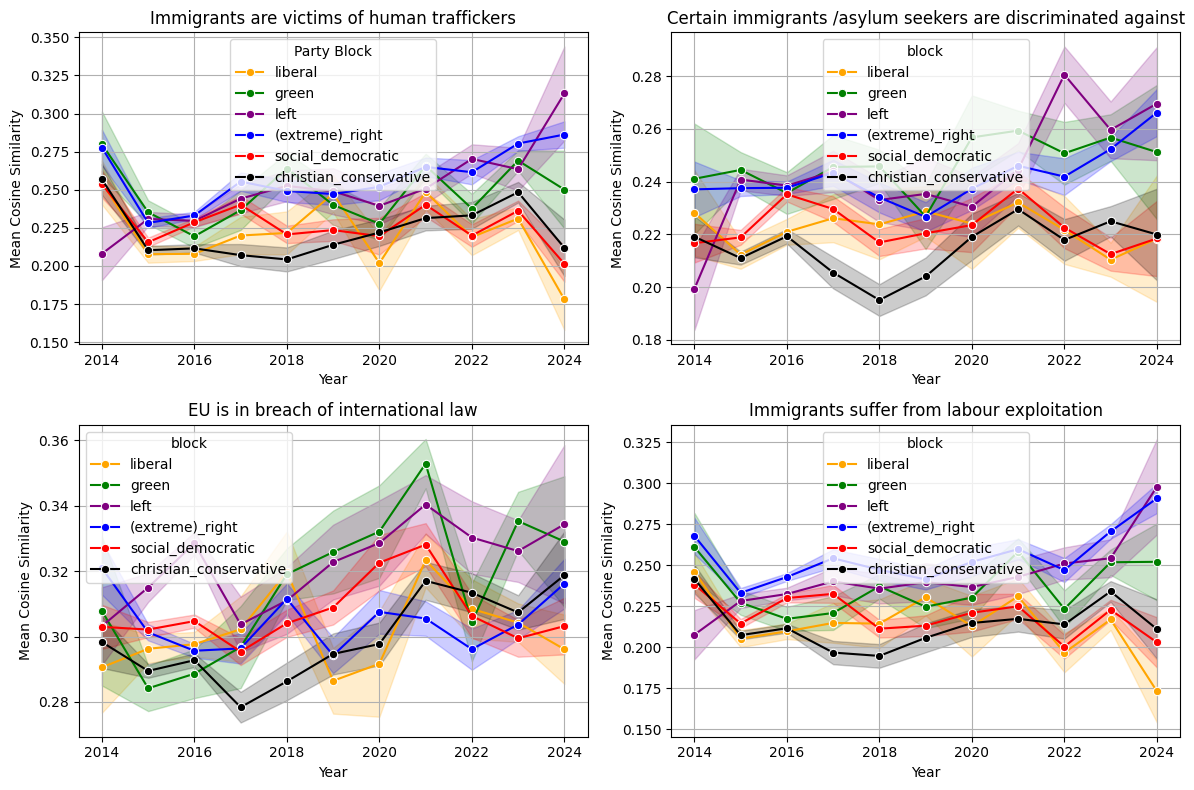

In [39]:
fig, axes = plt.subplots(len(queries)//2, 2, figsize=(12, 4 * len(queries)//2))
for ax, query in zip(axes.flatten(), queries):
    mean_similarity_plots(ax, df, query)
    # on first pass, set legend
    if ax == axes.flatten()[0]:
        ax.legend(title='Party Block')

plt.tight_layout()
plt.show()

Computing average similarity for category: anti_immigration
Computing average similarity for category: immigrants_as_victims
Computing average similarity for category: populist/anti-elitist


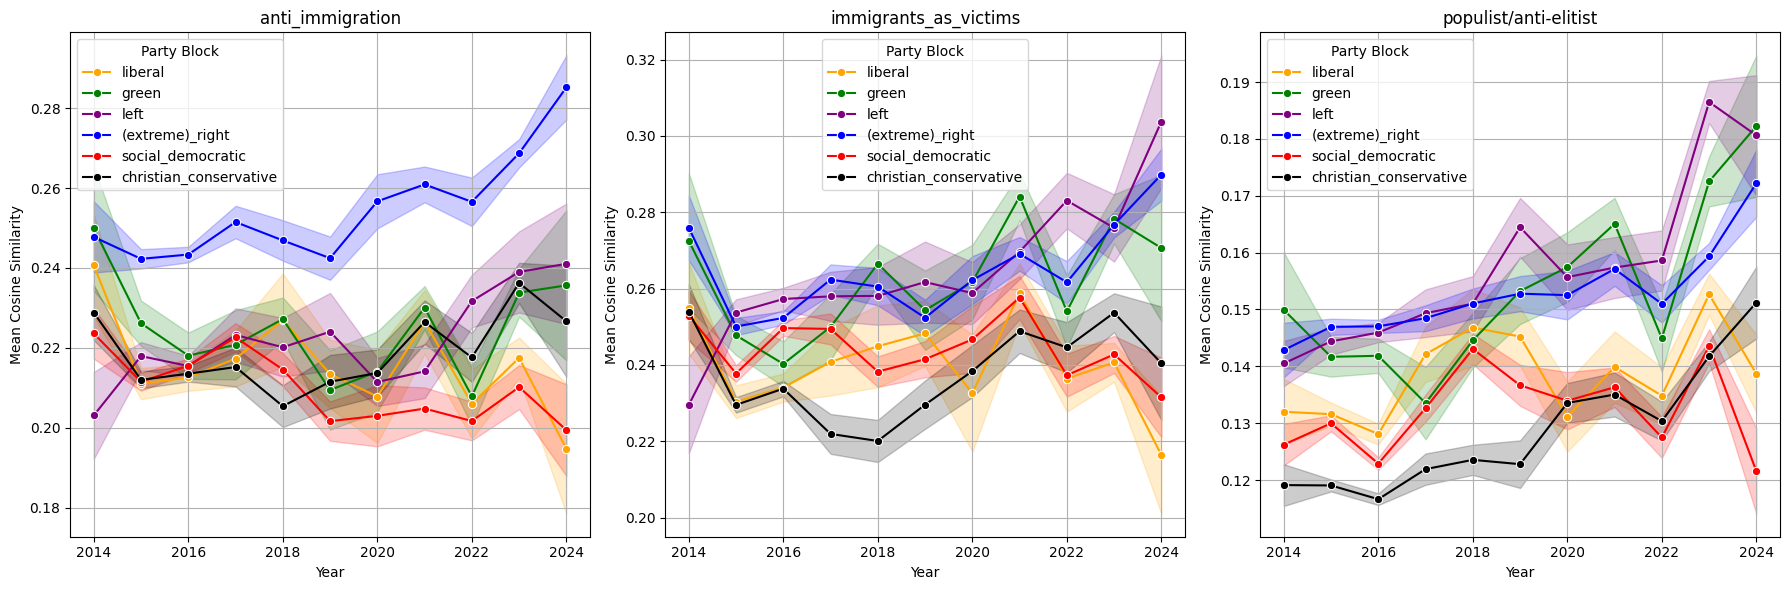

In [42]:
# compute average similarity for each category
for category, category_queries in query_dictionary.items():
    print(f"Computing average similarity for category: {category}")
    df[category] = df[category_queries].mean(axis=1)

# plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, category in zip(axes, query_dictionary.keys()):
    mean_similarity_plots(ax, df, category)
    ax.legend(title='Party Block')

plt.tight_layout()
plt.show()

In [41]:
# def plot_ratio_of_very_similar_speeches(df, query, percentile=90):
#     threshold = np.percentile(df[query], percentile)
#     # print(f"Threshold for {percentile}th percentile for query '{query}': {threshold:.4f}")

#     agg_percentile = (
#         df
#         .assign(above_percentile=lambda x: x[query] > threshold)
#         .groupby(["block", "year"])
#         .agg(n_speeches_above_percentile=("above_percentile", "sum"), n_speeches=(query, "size"))
#         .reset_index()
#     )

#     # print(agg_percentile.head())

#     # normalize by total speeches in each year
#     agg_percentile["ratio_above_percentile"] = (
#         agg_percentile["n_speeches_above_percentile"] / agg_percentile["n_speeches"]
#     )

#     fig, ax = plt.subplots(figsize=(12, 6))
#     sns.lineplot(data=agg_percentile, x='year', y='ratio_above_percentile',
#                  hue='block', marker='o', palette=color_map, ax=ax)
#     ax.set_title(f"Ratio of Speeches with Similarity in {percentile}th Percentile for Query: '{query}' by Party Block Over Years")
#     ax.set_ylabel("Ratio of Speeches")
#     ax.set_xlabel("Year")
#     ax.legend(title='Party Block')
#     ax.grid(True)
#     return fig
